In [1]:
from transformers import CLIPSegProcessor, CLIPSegForImageSegmentation

from PIL import Image
import torch
#import torchvision.transforms as T
import numpy as np

#from torchvision.transforms.functional import to_pil_image
#import matplotlib.pyplot as plt
import matplotlib.cm as cm

import cv2

from scipy.ndimage import gaussian_filter

from typing import Optional, Tuple

import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="torch")
warnings.filterwarnings("ignore", category=UserWarning, module="safetensors")



#matplotlib-inline==0.1.6
#open-clip-torch==2.24.0
#opencv-python==4.9.0.80
#pytorch-lightning==2.2.1
#torchaudio==2.1.2
#torchdiffeq==0.2.3
#torchmetrics==1.3.2

#torchsde==0.2.6
#torchvision==0.16.2

#scipy ??

In [2]:
def dilate_mask(mask: torch.Tensor, dilation_factor: float) -> torch.Tensor:
    """Dilate a mask using a square kernel with a given dilation factor."""
    kernel_size = int(dilation_factor * 2) + 1
    kernel = np.ones((kernel_size, kernel_size), np.uint8)
    mask_dilated = cv2.dilate(mask.numpy(), kernel, iterations=1)
    return torch.from_numpy(mask_dilated)

def apply_colormap(mask: torch.Tensor, colormap) -> np.ndarray:
    """Apply a colormap to a tensor and convert it to a numpy array."""
    colored_mask = colormap(mask.numpy())[:, :, :3]
    return (colored_mask * 255).astype(np.uint8)

def resize_image(image: np.ndarray, dimensions: Tuple[int, int]) -> np.ndarray:
    """Resize an image to the given dimensions using linear interpolation."""
    return cv2.resize(image, dimensions, interpolation=cv2.INTER_LINEAR)

def overlay_image(background: np.ndarray, foreground: np.ndarray, alpha: float) -> np.ndarray:
    """Overlay the foreground image onto the background with a given opacity (alpha)."""
    return cv2.addWeighted(background, 1 - alpha, foreground, alpha, 0)

def numpy_to_tensor(array: np.ndarray) -> torch.Tensor:
    """Convert a numpy array to a tensor and scale its values from 0-255 to 0-1."""
    array = array.astype(np.float32) / 255.0
    return torch.from_numpy(array)[None,]





### Aux ###

def to_image(t: torch.Tensor):
    if len(t.size()) > 3:
        i = t[0].numpy() 
    else:
        i = t.numpy()
    i = (i * 255).astype(np.uint8)
    return Image.fromarray(i, mode="RGB")

In [18]:
device = 'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'

#processor = CLIPSegProcessor.from_pretrained("CIDAS/clipseg-rd64-refined")
#model = CLIPSegForImageSegmentation.from_pretrained("CIDAS/clipseg-rd64-refined")
#model.to(device)

processor = CLIPSegProcessor.from_pretrained("clipseg-rd64-refined/")
model = CLIPSegForImageSegmentation.from_pretrained("clipseg-rd64-refined/")
model.to(device)

CLIPSegForImageSegmentation(
  (clip): CLIPSegModel(
    (text_model): CLIPSegTextTransformer(
      (embeddings): CLIPSegTextEmbeddings(
        (token_embedding): Embedding(49408, 512)
        (position_embedding): Embedding(77, 512)
      )
      (encoder): CLIPSegEncoder(
        (layers): ModuleList(
          (0-11): 12 x CLIPSegEncoderLayer(
            (self_attn): CLIPSegAttention(
              (k_proj): Linear(in_features=512, out_features=512, bias=True)
              (v_proj): Linear(in_features=512, out_features=512, bias=True)
              (q_proj): Linear(in_features=512, out_features=512, bias=True)
              (out_proj): Linear(in_features=512, out_features=512, bias=True)
            )
            (layer_norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
            (mlp): CLIPSegMLP(
              (activation_fn): QuickGELUActivation()
              (fc1): Linear(in_features=512, out_features=2048, bias=True)
              (fc2): Linear(in_features=20

In [19]:
import requests

url = "https://unsplash.com/photos/8Nc_oQsc2qQ/download?ixid=MnwxMjA3fDB8MXxhbGx8fHx8fHx8fHwxNjcxMjAwNzI0&force=true&w=640"
loaded_image = Image.open(requests.get(url, stream=True).raw)

# Code from ComfyUI core nodes

from PIL import ImageOps

i = ImageOps.exif_transpose(loaded_image)
if i.mode == 'I':
    i = i.point(lambda i: i * (1 / 255))
image = i.convert("RGB")
image = np.array(image).astype(np.float32) / 255.0
images = torch.from_numpy(image)[None,]

print("ComfyUI image shape:", images.size())

def image_to_mask(image, channel):
    channels = ["red", "green", "blue", "alpha"]
    mask = image[:, :, :, channels.index(channel)]
    return (mask,)

channel_mask = image_to_mask(images, "red")

print("ComfyUI mask from image shape:", channel_mask[0].size())
print()
print("ComfyUI image shape: [BATCH, HEIGHT, WIDTH, CHANNEL]")
print("ComfyUI mask shape: [BATCH, HEIGHT, WIDTH]")

#############
# Node code #
#############

image_np = images[0].numpy() 
# Convert the numpy array back to the original range (0-255) and data type (uint8)
image_np = (image_np * 255).astype(np.uint8)
# Create a PIL image from the numpy array
image_pil = Image.fromarray(image_np, mode="RGB")

print("image_np shape:", image_np.shape)

ComfyUI image shape: torch.Size([1, 960, 640, 3])
ComfyUI mask from image shape: torch.Size([1, 960, 640])

ComfyUI image shape: [BATCH, HEIGHT, WIDTH, CHANNEL]
ComfyUI mask shape: [BATCH, HEIGHT, WIDTH]
image_np shape: (960, 640, 3)


In [10]:
# Text prompt

text = "cutlery, pancakes, blueberries, orange juice"
prompt = text.split(',')

input_prc = processor(text=prompt, images=[image_pil] * len(prompt), padding=True, return_tensors="pt")
input_prc = input_prc.to(device)

with torch.no_grad():
    outputs = model(**input_prc)

Unused or unrecognized kwargs: padding.


In [20]:
# Visual prompt

url = "https://unsplash.com/photos/Ki7sAc8gOGE/download?ixid=MnwxMjA3fDB8MXxzZWFyY2h8MTJ8fGNvZmZlJTIwdG8lMjBnb3xlbnwwfHx8fDE2NzExOTgzNDQ&force=true&w=640"
visual_prompt = Image.open(requests.get(url, stream=True).raw)


encoded_image = processor(images=[image_pil], return_tensors="pt")
encoded_prompt = processor(images=[visual_prompt], return_tensors="pt")

encoded_image = encoded_image.to(device)
encoded_prompt = encoded_prompt.to(device)

# predict
with torch.no_grad():
  outputs = model(**encoded_image, conditional_pixel_values=encoded_prompt.pixel_values)

In [21]:
threshold = 0.4


masks = []
outputs = outputs[0].to('cpu')
if len(prompt) == 1:
    outputs = outputs.unsqueeze(0)

for output in outputs:
    tensor = torch.sigmoid(output) # get the mask

    # Apply a threshold to the original tensor to cut off low values
    tensor_thresholded = torch.where(tensor > threshold, torch.tensor(1, dtype=torch.float), torch.tensor(0, dtype=torch.float))
    masks.append(tensor_thresholded)

masks = torch.stack(masks).max(dim=0)[0]

print("masks", masks.shape)

masks torch.Size([352, 352])


In [22]:
blur = 7
dilation_factor = 4

# Apply Gaussian blur to the thresholded tensor
sigma = blur
tensor_smoothed = gaussian_filter(masks.numpy(), sigma=sigma)
tensor_smoothed = torch.from_numpy(tensor_smoothed)

# Normalize the smoothed tensor to [0, 1]
mask_normalized = (tensor_smoothed - tensor_smoothed.min()) / (tensor_smoothed.max() - tensor_smoothed.min())

print("mask normalized", mask_normalized.shape)

# Dilate the normalized mask
mask_dilated = dilate_mask(mask_normalized, dilation_factor)

print("mask dilated", mask_dilated.shape)

# Convert the mask to a heatmap and a binary mask
heatmap = apply_colormap(mask_dilated, cm.viridis)
binary_mask = apply_colormap(mask_dilated, cm.Greys_r)

print("heatmap", heatmap.shape)
print("binary mask", binary_mask.shape)

mask normalized torch.Size([352, 352])
mask dilated torch.Size([352, 352])
heatmap (352, 352, 3)
binary mask (352, 352, 3)


In [23]:
# Resize masks
dimensions = (image_np.shape[1], image_np.shape[0])
heatmap_resized = resize_image(heatmap, dimensions)
binary_mask_resized = resize_image(binary_mask, dimensions)

print("Heatmap resized shape", heatmap_resized.shape)
print("Binary mask resized shape", heatmap_resized.shape)

Heatmap resized shape (960, 640, 3)
Binary mask resized shape (960, 640, 3)


In [24]:
# Overlay the heatmap and binary mask on the original image
alpha_heatmap, alpha_binary = 0.5, 1
overlay_heatmap = overlay_image(image_np, heatmap_resized, alpha_heatmap)
overlay_binary = overlay_image(image_np, binary_mask_resized, alpha_binary)

# Convert the numpy arrays to tensors
image_out_heatmap = numpy_to_tensor(overlay_heatmap)
image_out_binary = numpy_to_tensor(overlay_binary)

print("Heatmap tensor shape", image_out_heatmap.size())
print("Binary mask tensor shape", image_out_binary.size())

Heatmap tensor shape torch.Size([1, 960, 640, 3])
Binary mask tensor shape torch.Size([1, 960, 640, 3])


In [25]:
tensor_bws = []
tensor_bws.append(image_out_binary[:, :, :, 0].squeeze(0))

result = torch.stack(tensor_bws)

print("Resulting mask tensor shape", result.size())

Resulting mask tensor shape torch.Size([1, 960, 640])


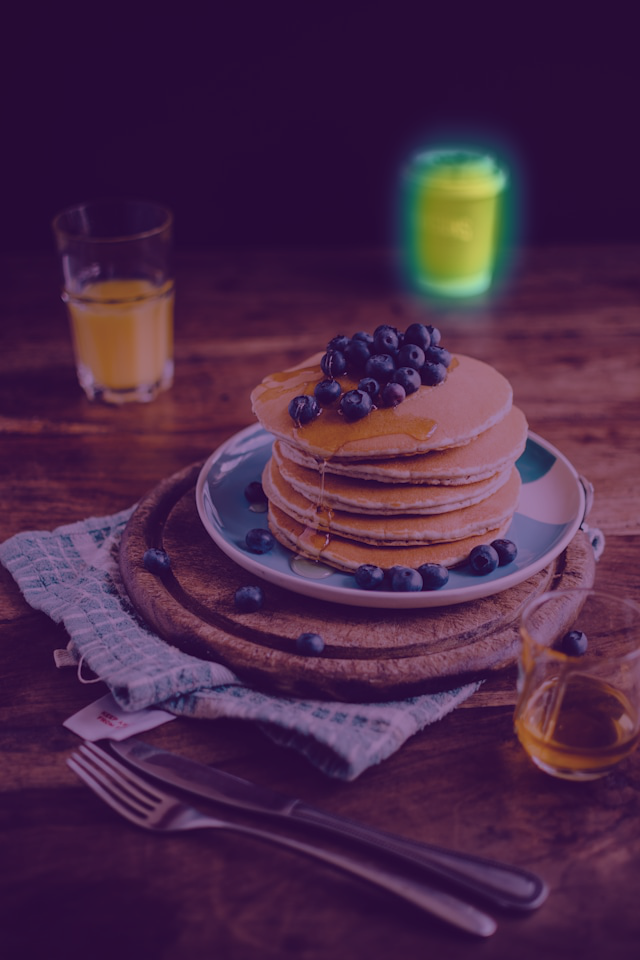

In [26]:
to_image(image_out_heatmap)